# % de Área Edificada em Campinas com Google OpenBuildings

In [1]:
import pandas as pd
import geopandas as gpd
import config as cfg
import utils as u
import matplotlib.pyplot as plt

## Preparação

Para a preparação dos dados eu fiz algumas funções bem simples no arquivo `utils.py` e variáveis no `config.py` só para limpar o código aqui e focar mais nos breves resultados da exploração.

##### GeoDataFrames de base:
* Limites de Campinas;
* Edificações (Building Footprints) do Google OpenBuildings já recortado por Campinas;
* Grid para os cálculos necessários.

#### GDF Campinas
* Filtragem de Campinas;
* Padronização do CRS (EPSG:4674);
* Cálculo da área da cidade em m²

<Axes: >

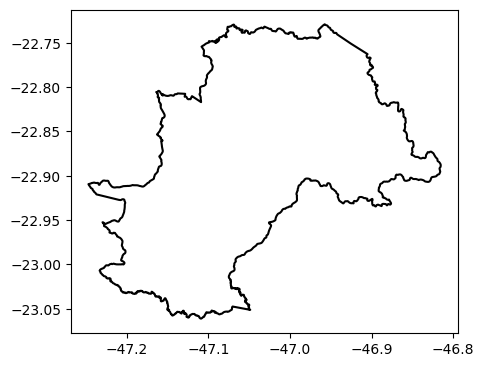

In [2]:
# IBGE - CAMPINAS/SP

GDF_MUN_CAMPINAS = u.gdf_creator_from_file(cfg.RAW_MUNS_SP,None)
GDF_MUN_CAMPINAS = GDF_MUN_CAMPINAS[GDF_MUN_CAMPINAS["CD_MUN"] == "3509502"] #Geocódigo de Campinas segundo o IBGE: 3509502
GDF_MUN_CAMPINAS["AREA_MUN_M2"] = u.calc_area(GDF_MUN_CAMPINAS,31983)
GDF_MUN_CAMPINAS = GDF_MUN_CAMPINAS[["CD_MUN","NM_MUN","SIGLA_UF","AREA_MUN_M2","geometry"]].reset_index(drop=True)



#Plotagem
GDF_MUN_CAMPINAS.boundary.plot(figsize=(5,5), edgecolor='black')

#### GDF Google OpenBuildings
* Filtragem de Campinas;
* Id genérico para os registros.

<Axes: >

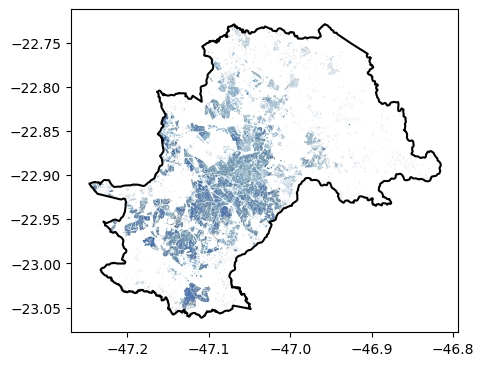

In [3]:
# GOOGLE OPENBUILDINGS

GDF_BFS_CAMPINAS = u.gdf_creator_from_file(cfg.RAW_BFS,GDF_MUN_CAMPINAS)
GDF_BFS_CAMPINAS["BF_ID"] = GDF_BFS_CAMPINAS.index
GDF_BFS_CAMPINAS = GDF_BFS_CAMPINAS[["BF_ID","geometry"]]



#Plotagem
fig, ax = plt.subplots(figsize=(5, 5))
GDF_BFS_CAMPINAS.plot(ax=ax)
GDF_MUN_CAMPINAS.boundary.plot(ax=ax, edgecolor='black')

#### GDF Grid
* Grid com 200m de lado por toda cidade;
* Intersecção Google OpenBuildings x Grid;
* Cálculo da área edificada por grid com preenchimento dos nulos;
* % da área edificada por grid.


<Axes: >

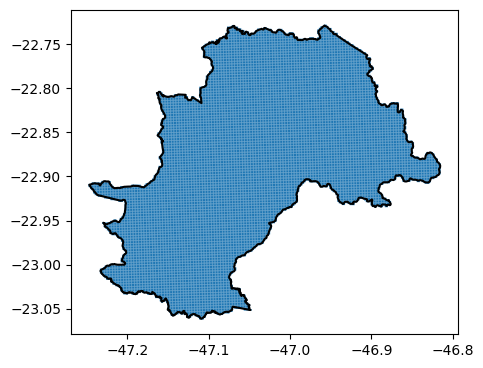

In [4]:
# GRID DE BASE PARA A ANÁLISE
GDF_GRID_CAMPINAS = u.create_grid(GDF_MUN_CAMPINAS,200)
GDF_GRID_CAMPINAS = GDF_GRID_CAMPINAS[["GRID_ID","CD_MUN","NM_MUN","SIGLA_UF","AREA_GRID_M2","AREA_MUN_M2","geometry"]]

# SOBREPOSICAO GRID X OPEN BUILDINGS
GDF_GRID_GBF_CAMPINAS = gpd.overlay(GDF_GRID_CAMPINAS,GDF_BFS_CAMPINAS,how='intersection',keep_geom_type=False)
GDF_GRID_GBF_CAMPINAS = GDF_GRID_GBF_CAMPINAS[["GRID_ID","geometry"]].dissolve("GRID_ID").reset_index()
GDF_GRID_GBF_CAMPINAS["AREA_BF_M2"] = u.calc_area(GDF_GRID_GBF_CAMPINAS,31983)

# ÁREA EDIFICADA NA MALHA DE GRIDS
GDF_GRID_CAMPINAS_FINAL = GDF_GRID_CAMPINAS[["GRID_ID","NM_MUN","SIGLA_UF","AREA_MUN_M2","AREA_GRID_M2","geometry"]].merge(GDF_GRID_GBF_CAMPINAS[["GRID_ID","AREA_BF_M2"]], how="left", left_on="GRID_ID", right_on="GRID_ID")
GDF_GRID_CAMPINAS_FINAL["AREA_BF_M2"].fillna(value=0, inplace=True)
GDF_GRID_CAMPINAS_FINAL["PERC_BUILT_AREA"] = (GDF_GRID_CAMPINAS_FINAL["AREA_BF_M2"] / GDF_GRID_CAMPINAS_FINAL["AREA_GRID_M2"])*100
del GDF_GRID_CAMPINAS, GDF_GRID_GBF_CAMPINAS



#Plotagem
fig, ax = plt.subplots(figsize=(5, 5))
GDF_GRID_CAMPINAS_FINAL.plot(ax=ax)
GDF_MUN_CAMPINAS.boundary.plot(ax=ax, edgecolor='black')

In [5]:
#GDF - Tabela
GDF_GRID_CAMPINAS_FINAL.head()


,GRID_ID,NM_MUN,SIGLA_UF,AREA_MUN_M2,AREA_GRID_M2,geometry,AREA_BF_M2,PERC_BUILT_AREA
0,0,Campinas,SP,7.947997e+08,40000.0,"POLYGON ((-47.24779 -22.91214, -47.24584 -22.9...",1381.644801,3.454112
1,1,Campinas,SP,7.947997e+08,40000.0,"POLYGON ((-47.24776 -22.91033, -47.24581 -22.9...",7956.724005,19.891810
2,2,Campinas,SP,7.947997e+08,40000.0,"POLYGON ((-47.24587 -22.91397, -47.24392 -22.9...",940.279342,2.350698
3,3,Campinas,SP,7.947997e+08,40000.0,"POLYGON ((-47.24584 -22.91217, -47.24389 -22.9...",848.298414,2.120746
4,4,Campinas,SP,7.947997e+08,40000.0,"POLYGON ((-47.24581 -22.91036, -47.24386 -22.9...",0.000000,0.000000


## Análise

##### GeoDataFrame de análise:
* Grid com diferentes classificações da Área Edificada por Grid.

#### GDF Análise
* Classificação do % Área Edificada;
* Classes de Percentis de concentração de maiores área edificadas.


##### Classificação - % Área Edificada
A quebra de classes foi a título de exemplo para esta breve análise. Ela veio da classificação de quebras naturais do percentual de área edificada de cada grid para as cinco classes:
* Muito Baixa: 0.0% - 5.0%
* Baixa: 5.0% - 16.0%
* Média: 16.0% - 28.0%
* Alta: 28.0% - 40%
* Muito Alta: 40% - 100%
  
Conforme legenda do gráfico abaixo:


Text(0.5, 1.0, '% Área Edificada')

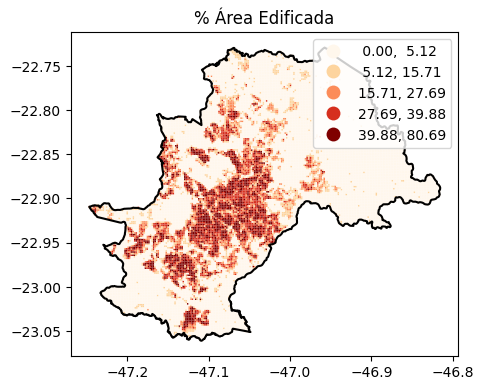

In [5]:
fig, ax = plt.subplots(figsize=(5, 5))

GDF_GRID_CAMPINAS_FINAL.plot(ax=ax, column="PERC_BUILT_AREA", cmap='OrRd', scheme='natural_breaks', k=5, legend=True)
GDF_MUN_CAMPINAS.boundary.plot(ax=ax, edgecolor='black')
ax.set_title("% Área Edificada")

#plt.savefig('img/perc_area_edificada.jpg')

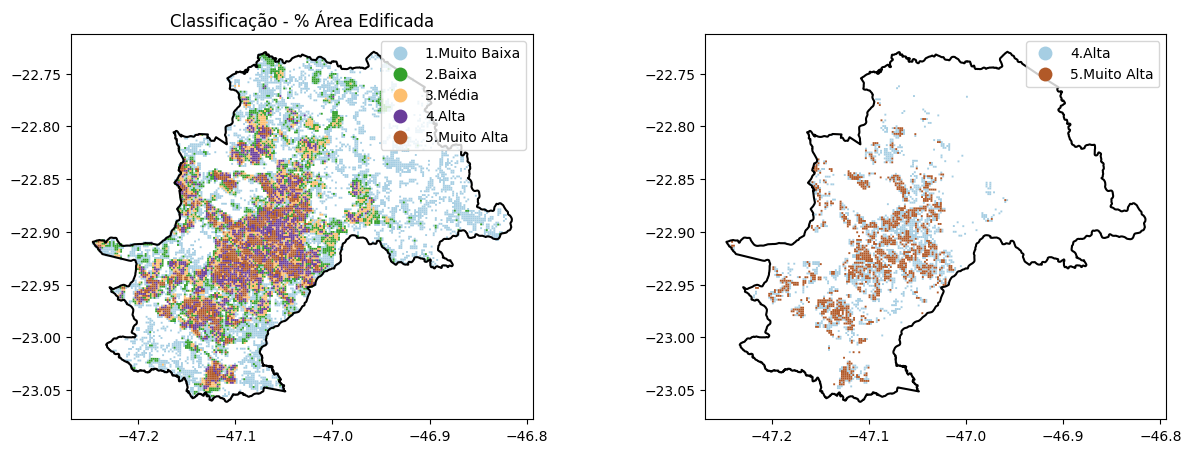

In [9]:
# CLASSES DE % DE AREA EDIFICADA
GDF_GRID_CAMPINAS_FINAL = u.generate_classes(GDF_GRID_CAMPINAS_FINAL, "CLASS_BUILT_AREA", "PERC_BUILT_AREA", cfg.bin_classes, cfg.label_classes)

#Plotagem
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
GDF_GRID_CAMPINAS_FINAL[GDF_GRID_CAMPINAS_FINAL["CLASS_BUILT_AREA"]!='N/A'].plot(ax=ax[0], column="CLASS_BUILT_AREA", cmap="Paired", legend=True)
GDF_MUN_CAMPINAS.boundary.plot(ax=ax[0], edgecolor='black')
GDF_GRID_CAMPINAS_FINAL[GDF_GRID_CAMPINAS_FINAL["CLASS_BUILT_AREA"].isin(['5.Muito Alta', '4.Alta'])].plot(ax=ax[1], column="CLASS_BUILT_AREA", cmap="Paired", legend=True)
GDF_MUN_CAMPINAS.boundary.plot(ax=ax[1], edgecolor='black')
ax[0].set_title("Classificação - % Área Edificada")

#plt.savefig('img/class_perc_area_edificada.jpg')

In [7]:
#GDF - Tabela
GDF_GRID_CAMPINAS_FINAL.head()

,GRID_ID,NM_MUN,SIGLA_UF,AREA_MUN_M2,AREA_GRID_M2,geometry,AREA_BF_M2,PERC_BUILT_AREA,CLASS_BUILT_AREA
0,0,Campinas,SP,7.947997e+08,40000.0,"POLYGON ((-47.24779 -22.91214, -47.24584 -22.9...",1381.644801,3.454112,1.Muito Baixa
1,1,Campinas,SP,7.947997e+08,40000.0,"POLYGON ((-47.24776 -22.91033, -47.24581 -22.9...",7956.724005,19.891810,3.Média
2,2,Campinas,SP,7.947997e+08,40000.0,"POLYGON ((-47.24587 -22.91397, -47.24392 -22.9...",940.279342,2.350698,1.Muito Baixa
3,3,Campinas,SP,7.947997e+08,40000.0,"POLYGON ((-47.24584 -22.91217, -47.24389 -22.9...",848.298414,2.120746,1.Muito Baixa
4,4,Campinas,SP,7.947997e+08,40000.0,"POLYGON ((-47.24581 -22.91036, -47.24386 -22.9...",0.000000,0.000000,N/A


##### Classificação - Concentração de áreas mais edificadas
A divisão em classes da área edificada em Campinas foi realizada com base nos percentis (Q) do acumulado da área. Q4, Q3 e Q2 concentram 75% das maiores áreas por grid. Cada Q representa 25% da área total. O Q4, por exemplo, reúne as 25% maiores áreas por grid, enquanto o Q1 reúne as 25% menores.

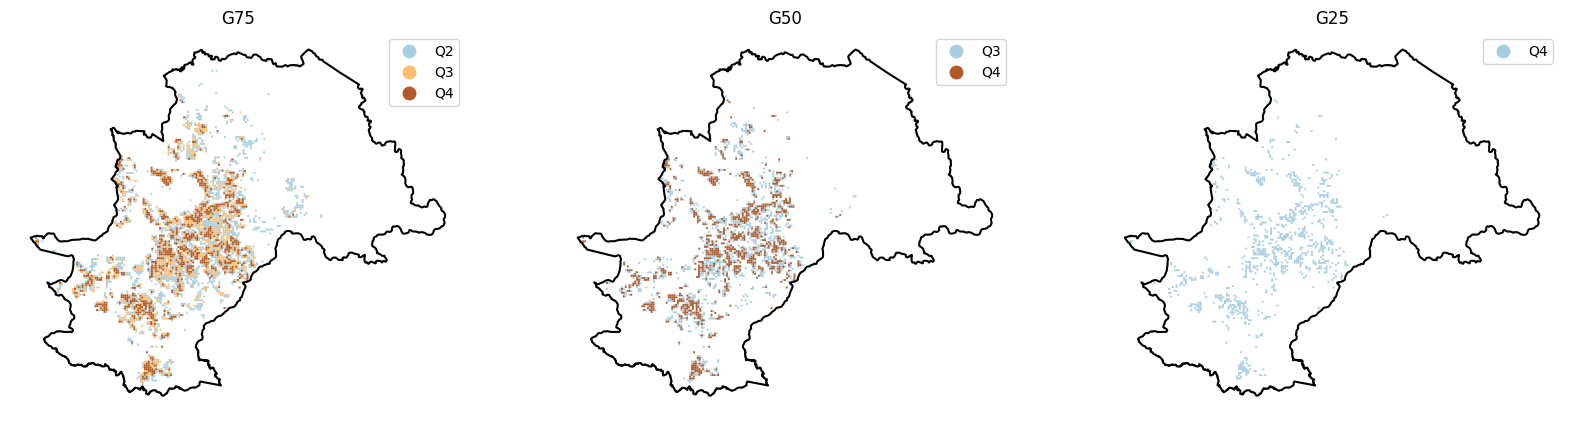

In [11]:
# CLASSES - CLUSTERIZAÇÃO GEOGRÁFICA - GRAHAGORY
GDF_GRID_CAMPINAS_FINAL = u.generate_quarteis(GDF_GRID_CAMPINAS_FINAL, "AREA_BF_M2","BUILT_AREA_QUARTEIS","PERC_CUM_BUILT_AREA", cfg.bin_quarteis, cfg.label_quarteis)


#Plotagem
fig, ax = plt.subplots(ncols=3, figsize=(20, 5))
GDF_GRID_CAMPINAS_FINAL[GDF_GRID_CAMPINAS_FINAL["BUILT_AREA_QUARTEIS"].isin(['Q4','Q3','Q2'])].plot(ax=ax[0], column="BUILT_AREA_QUARTEIS", cmap="Paired", legend=True)
GDF_MUN_CAMPINAS.boundary.plot(ax=ax[0], edgecolor='black')
GDF_GRID_CAMPINAS_FINAL[GDF_GRID_CAMPINAS_FINAL["BUILT_AREA_QUARTEIS"].isin(['Q4','Q3'])].plot(ax=ax[1], column="BUILT_AREA_QUARTEIS", cmap="Paired", legend=True)
GDF_MUN_CAMPINAS.boundary.plot(ax=ax[1], edgecolor='black')
GDF_GRID_CAMPINAS_FINAL[GDF_GRID_CAMPINAS_FINAL["BUILT_AREA_QUARTEIS"].isin(['Q4'])].plot(ax=ax[2], column="BUILT_AREA_QUARTEIS", cmap="Paired", legend=True)
GDF_MUN_CAMPINAS.boundary.plot(ax=ax[2], edgecolor='black')

ax[0].set_title("G75")
ax[0].set_axis_off();
ax[1].set_title("G50")
ax[1].set_axis_off();
ax[2].set_title("G25")
ax[2].set_axis_off();

#plt.savefig('img/class_quarteis_area_edificada.jpg')

In [ ]:
#GDF - Tabela
GDF_GRID_CAMPINAS_FINAL.head()